# Simple

In [1]:
import torch
from torch_geometric.data import Data

# Node features
x = torch.tensor([[1], [2], [3], [4]], dtype=torch.float)

# Edges (directed)
edge_index = torch.tensor([[0, 1, 2, 3, 0], [1, 2, 3, 0, 2]], dtype=torch.long)

# Create a simple graph
data = Data(x=x, edge_index=edge_index)


In [2]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F
import torch.nn as nn

class SimpleGATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SimpleGATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Instantiate the model
model = SimpleGATModel(in_channels=1, hidden_channels=8, out_channels=2)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = data.to(device)
model = model.to(device)

model.eval()
with torch.no_grad():
    out = model(data)

print("Output from GAT:", out)

Output from GAT: tensor([[-0.9282, -0.5029],
        [-0.8358, -0.5684],
        [-0.8299, -0.5728],
        [-0.9039, -0.5192]], device='cuda:0')


# Batched

In [4]:
from torch_geometric.data import Data

# Create three simple graphs
graph1 = Data(x=torch.randn(3, 4), edge_index=torch.tensor([[0, 1], [1, 2]]))
graph2 = Data(x=torch.randn(4, 4), edge_index=torch.tensor([[0, 1, 2], [1, 2, 3]]))
graph3 = Data(x=torch.randn(5, 4), edge_index=torch.tensor([[0, 1, 3, 4], [1, 2, 4, 0]]))

graphs = [graph1, graph2, graph3]


In [5]:
from torch_geometric.data import Batch

# Batch the graphs
batched_graph = Batch.from_data_list(graphs)
print(batched_graph)

DataBatch(x=[12, 4], edge_index=[2, 9], batch=[12], ptr=[4])


In [6]:
from torch_geometric.nn import global_mean_pool

class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Aggregate node features for each graph in the batch
        return x

# Instantiate the model for 4 features per node, hidden size of 8, and output size of 2
model = GATModel(in_channels=4, hidden_channels=8, out_channels=2)

In [7]:
model = model.to(device)
batched_graph = batched_graph.to(device)

model.eval()
with torch.no_grad():
    out = model(batched_graph.x, batched_graph.edge_index, batched_graph.batch)

print("Output for each graph in the batch:", out)


Output for each graph in the batch: tensor([[ 0.4257, -0.1969],
        [ 0.3806, -0.1568],
        [-0.0144, -0.4852]], device='cuda:0')


# List of batched graphs with regression

In [1]:
import torch
from torch_geometric.data import Data, Batch

# Example synthetic graphs with variable sizes
batch_1 = [Data(x=torch.randn(5, 4), edge_index=torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]], dtype=torch.long))]
batch_2 = [Data(x=torch.randn(3, 4), edge_index=torch.tensor([[0, 1], [1, 2]], dtype=torch.long)),
           Data(x=torch.randn(4, 4), edge_index=torch.tensor([[0, 1, 3], [1, 2, 0]], dtype=torch.long))]

# Example target values for each batch
targets = torch.tensor([1.5, 2.5], dtype=torch.float)  # Assume one target per batch

In [ ]:
# I want to use a Transformer for the attention in the attention. I also want to then output the graph feature importance.

In [141]:
from torch_geometric.nn import GATConv, global_mean_pool
import torch.nn.functional as F
import torch.nn as nn

class CustomGATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(CustomGATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        
        # Attention parameters
        self.attention_weight = nn.Parameter(torch.Tensor(1, hidden_channels))
        nn.init.xavier_uniform_(self.attention_weight.data)
        
        self.regressor = nn.Linear(hidden_channels, out_channels)

    def forward(self, batched_graphs):
        batched_graphs_representations = []
        
        for graph in batched_graphs:
            x, edge_index = graph.x, graph.edge_index
            x = F.relu(self.conv1(x, edge_index))
            x = self.conv2(x, edge_index)
            graph_rep = global_mean_pool(x, torch.zeros(x.size(0), dtype=torch.long))
            batched_graphs_representations.append(graph_rep)
        
        stacked_graphs = torch.stack(batched_graphs_representations)
        attention_scores = F.softmax(torch.matmul(stacked_graphs, self.attention_weight.t()), dim=0)
        weighted_graphs = attention_scores * stacked_graphs
        aggregated_representation = weighted_graphs.sum(dim=0)
        
        return self.regressor(aggregated_representation.unsqueeze(0))

In [142]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomGATModel(in_channels=4, hidden_channels=8, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Assuming batch_1 and batch_2 are prepared and available
batches = [batch_1, batch_2]
targets = targets.to(device)

for epoch in range(1000):  # Example: 10 epochs
    total_loss = 0
    for batch_graphs, target in zip(batches, targets):
        optimizer.zero_grad()
        prediction = model(batch_graphs).squeeze(-1)  # Adjust dimensions as necessary
        loss = criterion(prediction.squeeze(-1), target.unsqueeze(0))  # Ensure target is correctly shaped
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}: Loss = {total_loss / len(batches)}')

Epoch 1: Loss = 5.70572829246521
Epoch 2: Loss = 5.039193868637085
Epoch 3: Loss = 4.404805541038513
Epoch 4: Loss = 3.770244836807251
Epoch 5: Loss = 3.127368927001953
Epoch 6: Loss = 2.4923004806041718
Epoch 7: Loss = 1.8808511048555374
Epoch 8: Loss = 1.3253581002354622
Epoch 9: Loss = 0.8666664697229862
Epoch 10: Loss = 0.5506589123979211
Epoch 11: Loss = 0.3989603519439697
Epoch 12: Loss = 0.3771768808364868
Epoch 13: Loss = 0.4059327505528927
Epoch 14: Loss = 0.4133408199995756
Epoch 15: Loss = 0.37083821976557374
Epoch 16: Loss = 0.2901630220003426
Epoch 17: Loss = 0.1969689299003221
Epoch 18: Loss = 0.11430122726596892
Epoch 19: Loss = 0.05676121870055795
Epoch 20: Loss = 0.022949688602238894
Epoch 21: Loss = 0.007973676081746817
Epoch 22: Loss = 0.0050618820896488614
Epoch 23: Loss = 0.00774279423058033
Epoch 24: Loss = 0.011435679392889142
Epoch 25: Loss = 0.014049841091036797
Epoch 26: Loss = 0.015249293091983418
Epoch 27: Loss = 0.015510070137679577
Epoch 28: Loss = 0.01535

# Feature importance, Transformers for modeling batch graph attention

In [6]:
import torch
from torch_geometric.data import Data, Batch

# Example synthetic graphs with variable sizes
batch_1 = [Data(x=torch.randn(5, 4), edge_index=torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]], dtype=torch.long))]
batch_2 = [Data(x=torch.randn(3, 4), edge_index=torch.tensor([[0, 1], [1, 2]], dtype=torch.long)),
           Data(x=torch.randn(4, 4), edge_index=torch.tensor([[0, 1, 3], [1, 2, 0]], dtype=torch.long))]

# Example target values for each batch
targets = torch.tensor([1.5, 2.5], dtype=torch.float)  # Assume one target per batch

In [43]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv, global_mean_pool, TransformerConv

class TransformerGATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=2):
        super(TransformerGATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, concat=True)
        
        # Transformer layer for aggregating graph embeddings
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_channels, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers=1)
        
        self.regressor = nn.Linear(hidden_channels, out_channels)

    def forward(self, batched_graphs):
        batched_graphs_representations = []

        for graph in batched_graphs:
            x, edge_index = graph.x, graph.edge_index
            x = F.relu(self.conv1(x, edge_index))
            x = self.conv2(x, edge_index)
            # Apply global_mean_pool to obtain a 2D tensor for each graph: (1, hidden_channels)
            graph_rep = global_mean_pool(x, graph.batch).unsqueeze(0)  # Ensuring it's (1, hidden_channels)
            batched_graphs_representations.append(graph_rep)

        # Directly concatenating representations; they're already in the correct form: (1, hidden_channels)
        graphs_embeddings = torch.cat(batched_graphs_representations, dim=1)  # Corrected concatenation along the 'sequence length' dimension

        print(f"Graph Embeddings Shape after concatenation: {graphs_embeddings.shape}")

        # The tensor should already be in the desired shape (1, num_graphs, hidden_channels), no need for unsqueeze(0)
        transformed_embeddings = self.transformer_encoder(graphs_embeddings).squeeze(0)

        # Assuming we take the first graph's embedding for the regression task
        aggregated_representation = transformed_embeddings[0]

        return self.regressor(aggregated_representation)

In [44]:
model = TransformerGATModel(in_channels=4, hidden_channels=8, out_channels=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Assuming batch_1 and batch_2 are prepared and available
batches = [batch_1, batch_2]
targets = targets.to(device)

for epoch in range(10):  # Example: 10 epochs
    total_loss = 0
    for batch_graphs, target in zip(batches, targets):
        batch_graphs = [data.to(device) for data in batch_graphs]
        target = target.to(device)

        optimizer.zero_grad()
        prediction = model(batch_graphs)  # Transformer output ignored during training
        # prediction = prediction.squeeze(-1)
        loss = criterion(prediction, target.unsqueeze(0))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}: Loss = {total_loss / len(batches)}')

Graph Embeddings Shape after concatenation: torch.Size([1, 1, 8])
Graph Embeddings Shape after concatenation: torch.Size([1, 2, 8])
Epoch 1: Loss = 1.8528321981430054
Graph Embeddings Shape after concatenation: torch.Size([1, 1, 8])
Graph Embeddings Shape after concatenation: torch.Size([1, 2, 8])
Epoch 2: Loss = 1.109409049153328
Graph Embeddings Shape after concatenation: torch.Size([1, 1, 8])
Graph Embeddings Shape after concatenation: torch.Size([1, 2, 8])
Epoch 3: Loss = 0.5549232298508286
Graph Embeddings Shape after concatenation: torch.Size([1, 1, 8])
Graph Embeddings Shape after concatenation: torch.Size([1, 2, 8])
Epoch 4: Loss = 0.34817803045734763
Graph Embeddings Shape after concatenation: torch.Size([1, 1, 8])
Graph Embeddings Shape after concatenation: torch.Size([1, 2, 8])
Epoch 5: Loss = 0.27030055969953537
Graph Embeddings Shape after concatenation: torch.Size([1, 1, 8])
Graph Embeddings Shape after concatenation: torch.Size([1, 2, 8])
Epoch 6: Loss = 0.23133083432912

# Captum (interpretability)

In [349]:
model.embedding(torch.randint(0, 10, (5,1))[:, 0])

tensor([[-0.1351,  1.1669, -0.9262, -0.8257, -0.3861,  0.3903,  0.5441, -1.0211,
          0.5573,  0.3320,  0.6110,  0.5079, -0.2697,  1.4705,  0.9492, -0.0376],
        [-0.3726, -1.0210,  0.9684,  1.5519, -1.6162,  0.7513, -0.7545,  0.5429,
          0.6375,  0.2802,  0.5645,  0.1275, -1.9762, -1.8341,  1.5570, -1.8068],
        [ 2.9383, -2.2058,  1.4129, -0.7265, -0.4072, -1.9488,  1.2779,  0.2046,
         -1.7946,  0.0854, -0.2489, -0.0537,  0.8847,  1.4898, -1.2300, -0.7111],
        [-0.3702,  0.7118, -0.4895, -0.9216,  0.5241,  0.4836, -1.1000,  0.8136,
         -1.2032, -1.2309,  0.5547, -2.5203,  1.4530,  1.2069,  0.3703, -0.3149],
        [-0.7967,  1.4777, -1.2517, -1.9297,  1.0242,  1.7581,  1.0581, -1.9194,
          0.9537, -0.9572, -1.3933,  0.9033, -0.3585, -1.3424,  2.3679, -0.1724]],
       grad_fn=<EmbeddingBackward0>)

In [330]:
torch.randn(5,1)

tensor([[-1.0091],
        [-1.0722],
        [-1.6071],
        [ 0.6237],
        [-0.3591]])

## Embedding (doesn't work)

In [379]:
import torch
from torch_geometric.data import Data, Batch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool, TransformerConv

# Example synthetic graphs with variable sizes and categorical features (as indices)
num_node_features = 10  # Assuming 10 different categories for nodes
embedding_dim = 16  # Dimensionality of the embedding space
batch_1 = [Data(x=torch.randint(0, num_node_features, (5,1)), edge_index=torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]], dtype=torch.long))]
batch_2 = [Data(x=torch.randint(0, num_node_features, (3,1)), edge_index=torch.tensor([[0, 1], [1, 2]], dtype=torch.long)),
           Data(x=torch.randint(0, num_node_features, (4,1)), edge_index=torch.tensor([[0, 1, 3], [1, 2, 0]], dtype=torch.long))]

# Example target values for each batch
targets = torch.tensor([1.5, 2.5], dtype=torch.float)  # Assume one target per batch

class TransformerGATModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_channels, out_channels, num_heads=2):
        super(TransformerGATModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.conv1 = GATConv(embedding_dim, hidden_channels, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, concat=True)
        
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_channels, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers=1)
        
        self.attention_fc = torch.nn.Linear(hidden_channels, 1)
        self.regressor = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.embedding(x[:, 0].long())  # Embedding lookup
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Now x is (num_graphs, hidden_channels)
        
        attention_scores = self.attention_fc(x).squeeze(-1)  # Shape: (num_graphs,)
        attention_weights = F.softmax(attention_scores, dim=0)  # Shape: (num_graphs,)
        
        x = torch.sum(x * attention_weights.unsqueeze(-1), dim=0)  # Shape: (hidden_channels,)

        return self.regressor(x)

model = TransformerGATModel(num_embeddings=num_node_features, embedding_dim=embedding_dim, hidden_channels=8, out_channels=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

batches = [batch_1, batch_2]
targets = targets

model.train()
for epoch in range(10):  # Example: 10 epochs
    total_loss = 0
    for batch_graphs, target in zip(batches, targets):
        batched_data = Batch.from_data_list(batch_graphs)
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch

        optimizer.zero_grad()
        prediction = model(x, edge_index, batch).squeeze()
        loss = criterion(prediction, target)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}: Loss = {total_loss / len(batches)}')


Epoch 1: Loss = 3.0943110585212708
Epoch 2: Loss = 2.388317734003067
Epoch 3: Loss = 1.740965947508812
Epoch 4: Loss = 1.1382575891911983
Epoch 5: Loss = 0.7296831235289574
Epoch 6: Loss = 0.5646854788064957
Epoch 7: Loss = 0.4473808705806732
Epoch 8: Loss = 0.3433838002383709
Epoch 9: Loss = 0.2571139745414257
Epoch 10: Loss = 0.14878914155997336


## One hot (works)

In [365]:
import torch
from torch_geometric.data import Data, Batch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool, TransformerConv

# Example synthetic graphs with variable sizes and categorical features (as indices)
num_node_features = 10  # Assuming 10 different categories for nodes
embedding_dim = 16  # Dimensionality of the embedding space
batch_1 = [Data(x=F.one_hot(torch.randint(0, num_node_features, (5,)), num_classes=num_node_features).float(), edge_index=torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]], dtype=torch.long))]
batch_2 = [
    Data(x=F.one_hot(torch.randint(0, num_node_features, (3,)), num_classes=num_node_features).float(), edge_index=torch.tensor([[0, 1], [1, 2]], dtype=torch.long)),
    Data(x=F.one_hot(torch.randint(0, num_node_features, (4,)), num_classes=num_node_features).float(), edge_index=torch.tensor([[0, 1, 3], [1, 2, 0]], dtype=torch.long))
]

# Example target values for each batch
targets = torch.tensor([1.5, 2.5], dtype=torch.float)  # Assume one target per batch

class TransformerGATModel(nn.Module):
    def __init__(self, num_features, hidden_channels, out_channels, num_heads=2):
        super(TransformerGATModel, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, concat=True)
        
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_channels, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers=1)
        
        self.attention_fc = torch.nn.Linear(hidden_channels, 1)
        self.regressor = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # No embedding lookup needed, x is already one-hot encoded
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Now x is (num_graphs, hidden_channels)
        
        attention_scores = self.attention_fc(x).squeeze(-1)  # Shape: (num_graphs,)
        attention_weights = F.softmax(attention_scores, dim=0)  # Shape: (num_graphs,)
        
        x = torch.sum(x * attention_weights.unsqueeze(-1), dim=0)  # Shape: (hidden_channels,)

        return self.regressor(x)

model = TransformerGATModel(num_features=num_node_features, hidden_channels=8, out_channels=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

batches = [batch_1, batch_2]
targets = targets

model.train()
for epoch in range(10):  # Example: 10 epochs
    total_loss = 0
    for batch_graphs, target in zip(batches, targets):
        batched_data = Batch.from_data_list(batch_graphs)
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch

        optimizer.zero_grad()
        prediction = model(x, edge_index, batch).squeeze()
        loss = criterion(prediction, target)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}: Loss = {total_loss / len(batches)}')


Epoch 1: Loss = 3.978468418121338
Epoch 2: Loss = 3.380600333213806
Epoch 3: Loss = 2.767776906490326
Epoch 4: Loss = 2.1250728368759155
Epoch 5: Loss = 1.4657915830612183
Epoch 6: Loss = 0.8563261106610298
Epoch 7: Loss = 0.379573218524456
Epoch 8: Loss = 0.1423940286040306
Epoch 9: Loss = 0.17340817535296082
Epoch 10: Loss = 0.32862586341798306


## Split embedding and GNN

In [2]:
import torch
from torch_geometric.data import Data, Batch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

num_node_features = 10

# Example synthetic graphs with categorical features as indices
batch_1 = [Data(x=torch.randint(0, num_node_features, (5,1)), edge_index=torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]], dtype=torch.long))]
batch_2 = [Data(x=torch.randint(0, num_node_features, (3,1)), edge_index=torch.tensor([[0, 1], [1, 2]], dtype=torch.long)),
           Data(x=torch.randint(0, num_node_features, (4,1)), edge_index=torch.tensor([[0, 1, 3], [1, 2, 0]], dtype=torch.long))]

# Example target values for each batch
targets = torch.tensor([1.5, 2.5], dtype=torch.float)  # Assume one target per batch

In [3]:
class NodeFeatureEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(NodeFeatureEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        
    def forward(self, x):
        # Assuming x is of shape (num_nodes, 1) where each entry is the category index
        return self.embedding(x.squeeze())  # Embedding lookup and squeeze to drop extra dimension

class TransformerGATModel(nn.Module):
    def __init__(self, embedding_dim, hidden_channels, out_channels, num_heads=2):
        super(TransformerGATModel, self).__init__()
        self.conv1 = GATConv(embedding_dim, hidden_channels, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, concat=True)
        
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_channels, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers=1)
        
        self.attention_fc = torch.nn.Linear(hidden_channels, 1)
        self.regressor = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        
        attention_scores = self.attention_fc(x).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=0)
        
        x = torch.sum(x * attention_weights.unsqueeze(-1), dim=0)

        return self.regressor(x)

In [5]:
embedding_dim = 16 

embedding_module = NodeFeatureEmbedding(num_embeddings=num_node_features, embedding_dim=embedding_dim)
model = TransformerGATModel(embedding_dim=embedding_dim, hidden_channels=8, out_channels=1)


optimizer = torch.optim.Adam(list(embedding_module.parameters()) + list(model.parameters()), lr=0.01)
criterion = nn.MSELoss()

batches = [batch_1, batch_2]
targets = targets

model.train()
embedding_module.train()
for epoch in range(1):  # For example, 10 epochs
    total_loss = 0
    for batch_graphs, target in zip(batches, targets):
        batched_data = Batch.from_data_list(batch_graphs)
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        
        optimizer.zero_grad()
        
        # Embedding step
        embedded_x = embedding_module(x)
        
        # Model prediction
        prediction = model(embedded_x, edge_index, batch).squeeze()
        loss = criterion(prediction, target)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}: Loss = {total_loss / len(batches)}')

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Epoch 1: Loss = 0.0


## Explanation

In [404]:
from torch_geometric.explain import CaptumExplainer, Explainer, AttentionExplainer, DummyExplainer, GNNExplainer, GraphMaskExplainer

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(),
    explanation_type='model',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
    node_mask_type='object',
    edge_mask_type='object',
    # threshold_config=dict(
    #     threshold_type='topk',
    #     value=200,
    # ),
)

In [405]:
embedding_module(batched_data.x), batched_data

(tensor([[ 0.2318, -0.7330,  0.0937, -0.2265, -1.4654,  1.8962, -1.4301, -0.2911,
           1.2544, -1.0393, -0.8726, -0.8512,  0.3378,  0.2421, -1.2632, -0.9029],
         [-0.5159,  0.7221,  0.2068,  0.8916, -1.5426,  0.3701,  0.7634, -2.2375,
          -0.8007, -0.4983,  1.5802, -1.5427, -0.9859, -1.6191, -0.9459,  0.9179],
         [-0.5159,  0.7221,  0.2068,  0.8916, -1.5426,  0.3701,  0.7634, -2.2375,
          -0.8007, -0.4983,  1.5802, -1.5427, -0.9859, -1.6191, -0.9459,  0.9179],
         [-0.5159,  0.7221,  0.2068,  0.8916, -1.5426,  0.3701,  0.7634, -2.2375,
          -0.8007, -0.4983,  1.5802, -1.5427, -0.9859, -1.6191, -0.9459,  0.9179],
         [-0.8762, -2.2037, -0.1223,  0.5847,  0.2672, -0.1254,  0.5732,  1.1065,
           0.1983, -0.6314,  0.4182,  0.3535, -1.2620, -0.0181,  0.6575, -0.7783],
         [-0.7811,  0.0647,  1.6319, -0.9613,  0.2375,  0.0637,  0.8754, -1.5875,
           0.0560,  0.5753, -0.1972, -0.3851, -0.3808,  0.9382,  0.3022,  0.4016],
         [

In [416]:
model.eval()
embedding_module.eval()
batched_data = Batch.from_data_list(batch_2).to(device)
embedded_batched_data = embedding_module(batched_data.x).detach()
explanation = explainer(embedded_batched_data, batched_data.edge_index, batch=batch)
explanation

Explanation(node_mask=[7, 1], edge_mask=[5], prediction=[1], target=[1], x=[7, 16], edge_index=[2, 5], batch=[7])

In [224]:
import torch
from torch_geometric.data import Data, Batch

# Example synthetic graphs with variable sizes
batch_1 = [Data(x=torch.randn(5, 1), edge_index=torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]], dtype=torch.long))]
batch_2 = [Data(x=torch.randn(3, 1), edge_index=torch.tensor([[0, 1], [1, 2]], dtype=torch.long)),
           Data(x=torch.randn(4, 1), edge_index=torch.tensor([[0, 1, 3], [1, 2, 0]], dtype=torch.long))]

# Example target values for each batch
targets = torch.tensor([1.5, 2.5], dtype=torch.float)  # Assume one target per batch

In [ ]:
def collate(batch: list[list[Data]]) -> tuple[Batch, torch.Tensor]:
    batched_graphs, targets = [], []
    for graph in batch:
        batched_graph = Batch.from_data_list()

In [274]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv, global_mean_pool, TransformerConv

class TransformerGATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=2):
        super(TransformerGATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, concat=True)
        
        # Transformer layer for aggregating graph embeddings
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_channels, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers=1)
        
        self.attention_fc = torch.nn.Linear(hidden_channels, 1)
        self.regressor = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Now x is (num_graphs, hidden_channels)

        # Compute attention scores and normalize them
        attention_scores = self.attention_fc(x).squeeze(-1)  # Shape: (num_graphs,)
        attention_weights = F.softmax(attention_scores, dim=0)  # Shape: (num_graphs,)
        
        # Weighted aggregation of graph embeddings
        x = torch.sum(x * attention_weights.unsqueeze(-1), dim=0)  # Shape: (hidden_channels,)

        # Optional: Pass through transformer for further processing
        # x = x.unsqueeze(0)  # Add batch dimension
        # x = self.transformer_encoder(x)
        # x = x.squeeze(0)  # Remove batch dimension

        return self.regressor(x)

In [298]:
from torch_geometric.data import Batch

model = TransformerGATModel(in_channels=1, hidden_channels=8, out_channels=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = nn.MSELoss()

# Assuming batch_1 and batch_2 are prepared and available
batches = [batch_1, batch_2]
targets = targets.to(device)

model.train()
for epoch in range(1000):  # Example: 10 epochs
    total_loss = 0
    for batch_graphs, target in zip(batches, targets):
        # Prepare batched graph data
        batched_data = Batch.from_data_list(batch_graphs).to(device)
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        # Ensure target is a float tensor and has the correct shape
        target = target.to(device)

        optimizer.zero_grad()
        prediction = model(x, edge_index, batch).squeeze()
        # No need to squeeze if we ensure target and prediction shapes align
        loss = criterion(prediction, target)
        
        loss.backward()
        optimizer.step()
        # scheduler.step()
        
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}: Loss = {total_loss / len(batches)}')

Epoch 1: Loss = 4.371841907501221
Epoch 2: Loss = 3.530035376548767
Epoch 3: Loss = 2.757626533508301
Epoch 4: Loss = 2.033356010913849
Epoch 5: Loss = 1.3543277084827423
Epoch 6: Loss = 0.7552263513207436
Epoch 7: Loss = 0.3093621153384447
Epoch 8: Loss = 0.10194680467247963
Epoch 9: Loss = 0.15472016524290666
Epoch 10: Loss = 0.33475046418607235
Epoch 11: Loss = 0.43409615755081177
Epoch 12: Loss = 0.3825946431607008
Epoch 13: Loss = 0.2551683522760868
Epoch 14: Loss = 0.14377659768797457
Epoch 15: Loss = 0.08711149916052818
Epoch 16: Loss = 0.07504083774983883
Epoch 17: Loss = 0.08002956444397569
Epoch 18: Loss = 0.07950342446565628
Epoch 19: Loss = 0.06498551060758473
Epoch 20: Loss = 0.03992889776418451
Epoch 21: Loss = 0.015051940880312031
Epoch 22: Loss = 0.0015987755032256246
Epoch 23: Loss = 0.0034611260052770376
Epoch 24: Loss = 0.01312545221298933
Epoch 25: Loss = 0.01812074752524495
Epoch 26: Loss = 0.013587004039436579
Epoch 27: Loss = 0.005173133919015527
Epoch 28: Loss =

In [307]:
from torch_geometric.explain import CaptumExplainer, Explainer, AttentionExplainer, DummyExplainer, GNNExplainer, GraphMaskExplainer

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(),
    explanation_type='model',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
    node_mask_type='object',
    edge_mask_type='object',
    # threshold_config=dict(
    #     threshold_type='topk',
    #     value=200,
    # ),
)

In [311]:
x.shape

torch.Size([7])

In [308]:
batched_data = Batch.from_data_list(batch_2).to(device)
x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
explanation = explainer(batched_data.x, batched_data.edge_index, batch=batch)
explanation

ValueError: not enough values to unpack (expected 2, got 1)

In [278]:
explanation["edge_mask"]

tensor([0.8616, 0.8292, 0.7333, 0.7463, 0.7062])

In [279]:
explanation["node_mask"]

tensor([[0.2748],
        [0.2871],
        [0.2882],
        [0.2677],
        [0.6105],
        [0.2391],
        [0.7181]])

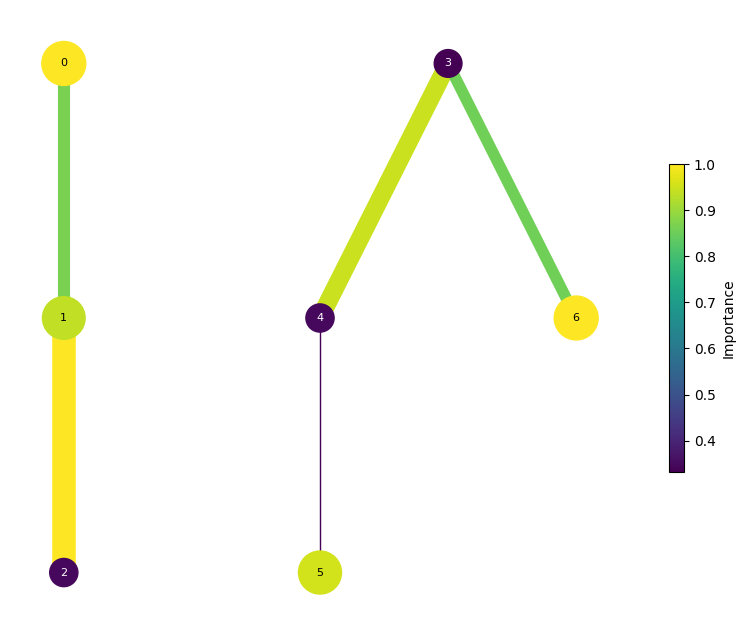

In [417]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np

# Assuming 'edge_index', 'explanation["node_mask"]', and 'explanation["edge_mask"]' are correctly defined
G = nx.Graph()
edge_index_np = edge_index.cpu().numpy()
for source, target in edge_index_np.T:
    G.add_edge(int(source), int(target))

# Normalize node and edge importance scores for visualization
node_importance = explanation["node_mask"].cpu().numpy()
edge_importance = explanation["edge_mask"].cpu().numpy()
node_importance_normalized = node_importance / node_importance.max()
edge_importance_normalized = edge_importance / edge_importance.max()

# Define the colormap and normalization
cmap = plt.cm.viridis
norm_node = mcolors.Normalize(vmin=node_importance_normalized.min(), vmax=node_importance_normalized.max())
norm_edge = mcolors.Normalize(vmin=edge_importance_normalized.min(), vmax=edge_importance_normalized.max())

fig, ax = plt.subplots(figsize=(10, 8))

# Use PyGraphviz to find the tree layout
pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

# Node sizes and colors based on importance
node_sizes = 100 + 900 * node_importance_normalized
node_colors = [cmap(norm_node(value)) for value in node_importance_normalized]

# Apply a power transformation to increase variation in edge widths
edge_widths = 1 + np.power(edge_importance_normalized * 2, 4)  # Adjust the exponent as needed

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, ax=ax)

# Draw edges with colors and widths based on their importance
edges = edge_index_np.T
edge_colors = [cmap(norm_edge(edge_importance_normalized[i])) for i in range(len(edges))]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths, edge_color=edge_colors, ax=ax)

# Draw node labels with contrasting colors for readability
for node, (x, y) in pos.items():
    label_color = 'white' if np.mean(node_colors[node]) < 0.5 else 'black'
    plt.text(x, y, str(node), ha='center', va='center', color=label_color, fontsize=8)

plt.axis('off')

# Add colorbar as a legend for node and edge importance
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_node)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Importance')

plt.show()


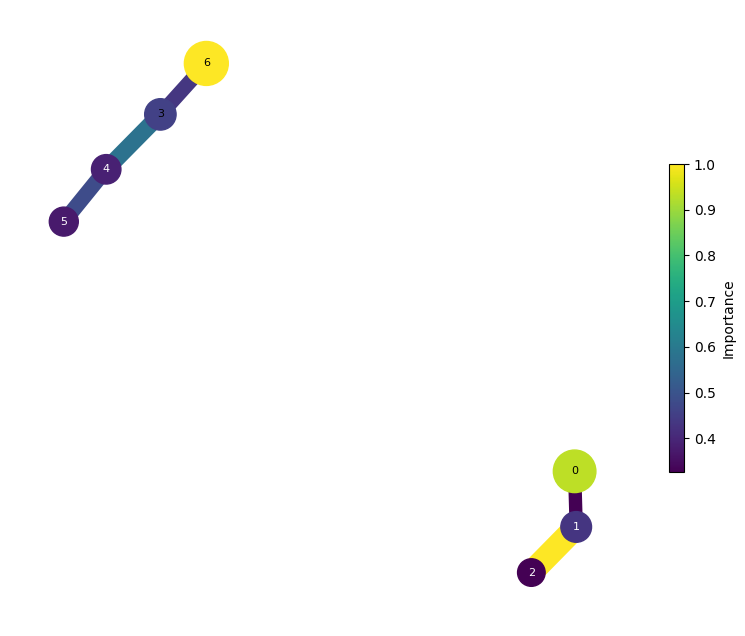

In [364]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np

# Assuming 'edge_index', 'explanation["node_mask"]', and 'explanation["edge_mask"]' are correctly defined
G = nx.Graph()
edge_index_np = edge_index.cpu().numpy()
for source, target in edge_index_np.T:
    G.add_edge(int(source), int(target))

# Ensuring the graph is a tree (for demonstration)
# For real data, ensure your graph construction logic correctly reflects its tree structure

# Normalize node and edge importance scores for visualization
node_importance = explanation["node_mask"].cpu().numpy()
edge_importance = explanation["edge_mask"].cpu().numpy()
node_importance_normalized = node_importance / node_importance.max()
edge_importance_normalized = edge_importance / edge_importance.max()

# Define the colormap and normalization
cmap = plt.cm.viridis
norm_node = mcolors.Normalize(vmin=node_importance_normalized.min(), vmax=node_importance_normalized.max())
norm_edge = mcolors.Normalize(vmin=edge_importance_normalized.min(), vmax=edge_importance_normalized.max())

# Assuming a tree layout
# This simple approach uses hierarchy.tree_layout if available, or a basic planar layout as fallback
try:
    # Newer networkx versions
    pos = nx.drawing.layout.hierarchy.tree_layout(G)
except AttributeError:
    # Fallback for older networkx versions or missing functionality
    pos = nx.spring_layout(G)

fig, ax = plt.subplots(figsize=(10, 8))

# Node sizes and colors based on importance
node_sizes = 100 + 900 * node_importance_normalized
node_colors = [cmap(norm_node(value)) for value in node_importance_normalized]

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, ax=ax)
edge_widths = 1 + np.power(edge_importance_normalized * 2, 4)  # Adjust as needed
edges = edge_index_np.T
edge_colors = [cmap(norm_edge(edge_importance_normalized[i])) for i in range(len(edges))]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths, edge_color=edge_colors, ax=ax)

# Draw labels
for node, (x, y) in pos.items():
    label_color = 'white' if np.mean(node_colors[node]) < 0.5 else 'black'
    plt.text(x, y, str(node), ha='center', va='center', color=label_color, fontsize=8)

plt.axis('off')

# Colorbar for node importance
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_node)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Importance')

plt.show()

In [122]:
def compatible_forward_func(x, edge_index, batch):
    # Ensure model output matches expected shape for IntegratedGradients
    return model(x, edge_index, batch).unsqueeze(-1)


In [106]:
# Preparing your input graph
input_graph = Batch.from_data_list(batch_1).to(device)  # Assume batch_1 is a list of Data objects
x, edge_index, batch = input_graph.x, input_graph.edge_index, input_graph.batch

# Create a baseline that matches the input's structure but consists of zeros
baseline_tuple = (torch.zeros_like(x), edge_index, batch)  # Assuming edge_index and batch do not require gradients

# Combine x, edge_index, and batch into a tuple for IG
input_tuple = (x, edge_index, batch)


# Categorical Captum Nodes

In [299]:
from torch_geometric.data import Data
import torch

# Assume 1 numeric feature (float) and 1 categorical feature (integer)
batch_1 = [Data(x=torch.randn(5, 2), edge_index=torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]], dtype=torch.long))]
batch_1[0].x[:, 1] = torch.randint(0, 3, (5,))  # Assuming 3 categories for the categorical feature

batch_2 = [Data(x=torch.randn(3, 2), edge_index=torch.tensor([[0, 1], [1, 2]], dtype=torch.long)),
           Data(x=torch.randn(4, 2), edge_index=torch.tensor([[0, 1, 3], [1, 2, 0]], dtype=torch.long))]
for data in batch_2:
    data.x[:, 1] = torch.randint(0, 3, (data.x.size(0),))  # Similarly, assigning categorical features

# Example target values for each batch
targets = torch.tensor([1.5, 2.5], dtype=torch.float)


In [304]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class TransformerGATModel(nn.Module):
    def __init__(self, num_numeric_features, categorical_feature_dimensions, hidden_channels, out_channels, num_heads=2):
        super(TransformerGATModel, self).__init__()
        
        # Create embedding layers for each categorical feature
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=dim, embedding_dim=embedding_size)
            for dim, embedding_size in categorical_feature_dimensions
        ])
        
        total_embedding_size = sum(embedding_size for _, embedding_size in categorical_feature_dimensions)
        total_in_channels = num_numeric_features + total_embedding_size

        self.conv1 = GATConv(total_in_channels, hidden_channels, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, concat=True)
        
        # Transformer layer
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_channels, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers=1)
        
        self.attention_fc = torch.nn.Linear(hidden_channels, 1)
        self.regressor = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_numeric, x_categorical, edge_index, batch):
        # Embed categorical features and concatenate with numeric features
        embeddings = [embedding(x_categorical[:, i]) for i, embedding in enumerate(self.embeddings)]
        x = torch.cat([x_numeric] + embeddings, dim=1)
        
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        
        attention_scores = self.attention_fc(x).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=0)
        x = torch.sum(x * attention_weights.unsqueeze(-1), dim=0)

        return self.regressor(x)

In [305]:
from torch_geometric.data import Batch

model = TransformerGATModel(
    num_numeric_features=1,  # We have 1 numeric feature
    categorical_feature_dimensions=[(3, 4)],  # One categorical feature with 3 categories and embedding size of 4
    hidden_channels=8,
    out_channels=1
).to(device)  # Use 'cuda' if you're running on a GPU

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

batches = [batch_1, batch_2]
targets = targets.to('cpu')  # Move targets to the same device as your model

model.train()
for epoch in range(10):  # Let's assume 10 epochs for brevity
    total_loss = 0
    for batch_graphs, target in zip(batches, targets):
        batched_data = Batch.from_data_list(batch_graphs).to('cpu')
        # Separate numeric and categorical features
        x_numeric = batched_data.x[:, [0]]  # Assuming the first column is numeric
        x_categorical = batched_data.x[:, 1].long()  # Assuming the second column is categorical
        edge_index, batch = batched_data.edge_index, batched_data.batch
        
        optimizer.zero_grad()
        prediction = model(x_numeric, x_categorical, edge_index, batch).squeeze()
        loss = criterion(prediction, target.unsqueeze(0))  # Make sure target is correctly shaped
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}: Loss = {total_loss / len(batches)}')

IndexError: too many indices for tensor of dimension 1

# Simplified GAT for captum

In [130]:
import torch
from torch_geometric.data import Data, Batch

# Example synthetic graphs with variable sizes
batch_1 = [Data(x=torch.randn(5, 4), edge_index=torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]], dtype=torch.long))]
batch_2 = [Data(x=torch.randn(3, 4), edge_index=torch.tensor([[0, 1], [1, 2]], dtype=torch.long)),
           Data(x=torch.randn(4, 4), edge_index=torch.tensor([[0, 1, 3], [1, 2, 0]], dtype=torch.long))]

# Example target values for each batch
targets = torch.tensor([1.5, 2.5], dtype=torch.float)  # Assume one target per batch

In [131]:
class SimplifiedGATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=2):
        super(SimplifiedGATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, concat=True)
        self.regressor = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        return self.regressor(x)


In [132]:
from torch_geometric.data import Batch

model = TransformerGATModel(in_channels=4, hidden_channels=8, out_channels=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Assuming batch_1 and batch_2 are prepared and available
batches = [batch_1, batch_2]
targets = targets.to(device)

for epoch in range(10):  # Example: 10 epochs
    total_loss = 0
    for batch_graphs, target in zip(batches, targets):
        # Prepare batched graph data
        batched_data = Batch.from_data_list(batch_graphs).to(device)
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        # Ensure target is a float tensor and has the correct shape
        target = target.to(device)

        optimizer.zero_grad()
        prediction = model(x, edge_index, batch).squeeze()
        # No need to squeeze if we ensure target and prediction shapes align
        loss = criterion(prediction, target)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}: Loss = {total_loss / len(batches)}')

Epoch 1: Loss = 2.7841637134552
Epoch 2: Loss = 1.643030434846878
Epoch 3: Loss = 1.23000318557024
Epoch 4: Loss = 0.8688380271196365
Epoch 5: Loss = 0.5942750629037619
Epoch 6: Loss = 0.4000081276608398
Epoch 7: Loss = 0.291634077206254
Epoch 8: Loss = 0.35051050782203674
Epoch 9: Loss = 0.286686435341835
Epoch 10: Loss = 0.13467897474765778


In [133]:
def ig_forward(x, edge_index, batch):
    # Ensure the model is in evaluation mode for consistent output
    model.eval()
    # Forward pass through the model
    logits = model(x, edge_index, batch)
    # Return the logits or a specific prediction
    return logits

from torch_geometric.data import Batch

# Assuming `data_list` is your list of graph data instances
input_batch = Batch.from_data_list(batch_1).to(device)

# Prepare your inputs
x = input_batch.x
edge_index = input_batch.edge_index
batch = input_batch.batch

In [134]:
from captum.attr import IntegratedGradients

# Initialize Integrated Gradients with your forward function
ig = IntegratedGradients(ig_forward)

# Define a baseline (here, zeros with the same shape as your input features)
baseline_x = torch.zeros_like(x)

# Calculate attributions
attributions, delta = ig.attribute(inputs=x,
                                    baselines=baseline_x,
                                    additional_forward_args=(edge_index, batch),
                                    target=0,  # Specify the target class or regression output
                                    return_convergence_delta=True)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 100 but got size 2 for tensor number 1 in the list.

# Working example from torch geometric

In [148]:
import os
import torch
%matplotlib inline
import matplotlib.pyplot as plt

In [149]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset

path = '.'
dataset = TUDataset("/home/fox/projects/general/learning-portfolio/university/masters/masters-thesis/data/tu_dataset", name='Mutagenicity').shuffle()
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

In [150]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g

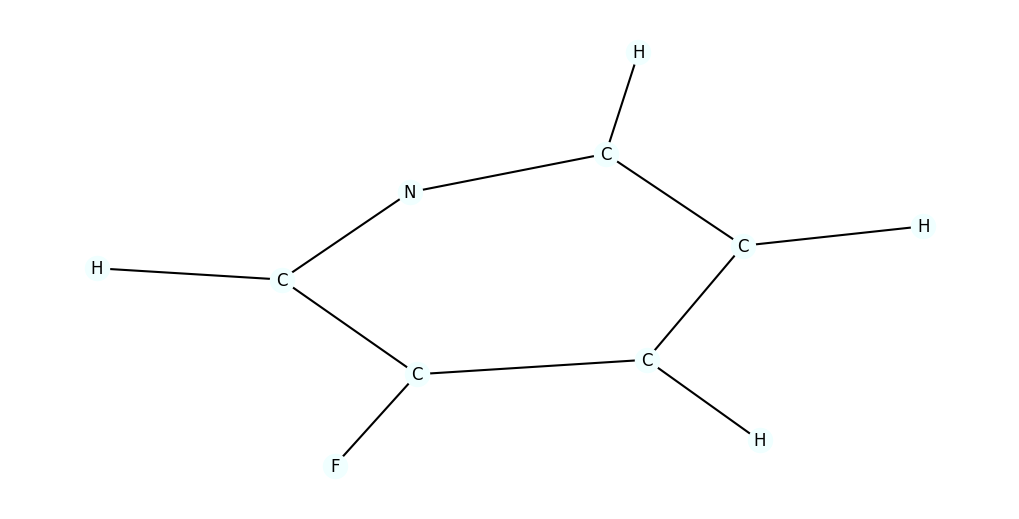

In [152]:
import random

data = random.choice([t for t in train_dataset])
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

In [153]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GraphConv, global_add_pool

class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

In [154]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [155]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 0.7534, Train Acc: 0.6575, Test Acc: 0.6259
Epoch: 002, Loss: 0.6313, Train Acc: 0.6609, Test Acc: 0.6328
Epoch: 003, Loss: 0.6098, Train Acc: 0.6947, Test Acc: 0.6559
Epoch: 004, Loss: 0.5942, Train Acc: 0.7057, Test Acc: 0.6674
Epoch: 005, Loss: 0.5810, Train Acc: 0.7154, Test Acc: 0.6721
Epoch: 006, Loss: 0.5732, Train Acc: 0.7303, Test Acc: 0.6790
Epoch: 007, Loss: 0.5532, Train Acc: 0.7436, Test Acc: 0.6998
Epoch: 008, Loss: 0.5606, Train Acc: 0.7395, Test Acc: 0.6882
Epoch: 009, Loss: 0.5443, Train Acc: 0.7549, Test Acc: 0.7182
Epoch: 010, Loss: 0.5403, Train Acc: 0.7462, Test Acc: 0.7159
Epoch: 011, Loss: 0.5261, Train Acc: 0.7674, Test Acc: 0.7506
Epoch: 012, Loss: 0.5303, Train Acc: 0.7741, Test Acc: 0.7413
Epoch: 013, Loss: 0.5203, Train Acc: 0.7725, Test Acc: 0.7390
Epoch: 014, Loss: 0.5192, Train Acc: 0.7784, Test Acc: 0.7598
Epoch: 015, Loss: 0.5096, Train Acc: 0.7713, Test Acc: 0.7344
Epoch: 016, Loss: 0.5066, Train Acc: 0.7864, Test Acc: 0.7691
Epoch: 0

In [156]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

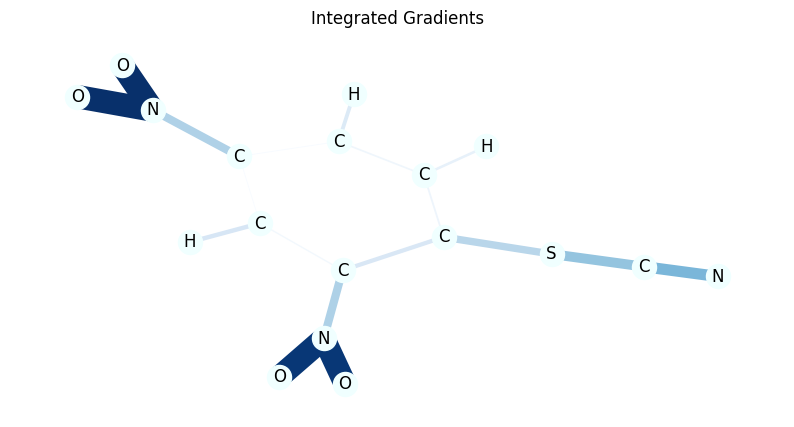

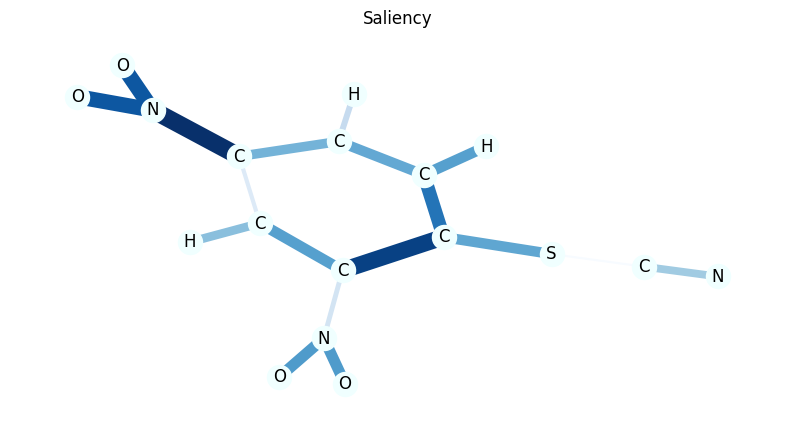

In [158]:
import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict


data = random.choice([t for t in test_dataset if not t.y.item()])
data.to(device)
mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

# Captum Explainer torch_geometric

In [166]:
import os.path as osp

import torch
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.explain import CaptumExplainer, Explainer
from torch_geometric.nn import GCNConv

dataset = 'Cora'
dataset = Planetoid("/home/fox/projects/general/learning-portfolio/university/masters/masters-thesis/data/planetoid_dataset", dataset)
data = dataset[0]


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for _ in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    node_mask_type='attributes',
    edge_mask_type='object',
    threshold_config=dict(
        threshold_type='topk',
        value=200,
    ),
)

node_index = 10
explanation = explainer(data.x, data.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance.png'
explanation.visualize_feature_importance(path, top_k=10)
print(f"Feature importance plot has been saved to '{path}'")

path = 'subgraph.pdf'
explanation.visualize_graph(path)
print(f"Subgraph plot has been saved to '{path}'")

Processing...
Done!


Generated explanations in ['edge_mask', 'node_mask']
Feature importance plot has been saved to 'feature_importance.png'
Subgraph plot has been saved to 'subgraph.pdf'


In [359]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Linear

import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.explain import CaptumExplainer, Explainer, GNNExplainer
from torch_geometric.nn import SAGEConv, to_hetero

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = MovieLens("data/MovieLens", model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
data['user', 'movie'].edge_label = data['user',
                                        'movie'].edge_label.to(torch.float)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
data, _, _ = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)


class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


model = Model(hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 10):
    model.train()
    optimizer.zero_grad()
    pred = model(
        data.x_dict,
        data.edge_index_dict,
        data['user', 'movie'].edge_label_index,
    )
    loss = F.mse_loss(pred, data['user', 'movie'].edge_label)
    loss.backward()
    optimizer.step()

explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='regression',
        task_level='edge',
        return_type='raw',
    ),
    node_mask_type='attributes',
    edge_mask_type='object',
    threshold_config=dict(
        threshold_type='topk',
        value=200,
    ),
)

index = torch.tensor([2, 10])  # Explain edge labels with index 2 and 10.
explanation = explainer(
    data.x_dict,
    data.edge_index_dict,
    index=index,
    edge_label_index=data['user', 'movie'].edge_label_index,
)
print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance.png'
explanation.visualize_feature_importance(path, top_k=10)
print(f"Feature importance plot has been saved to '{path}'")

Generated explanations in ['edge_mask', 'node_mask']
Feature importance plot has been saved to 'feature_importance.png'
